In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Barents = pd.read_excel(filepath, sheet_name='Barents-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Barents)
fp.date_time(Barents)

,Extent,Date
0,1107873.946,1979-01-01
1,1211101.473,1979-02-01
2,1215128.770,1979-03-01
3,1233940.811,1979-04-01
4,1193061.566,1979-05-01
...,...,...
533,124025.343,2023-06-01
534,53107.426,2023-07-01
535,11242.827,2023-08-01
536,3272.024,2023-09-01


In [5]:
scaler = MinMaxScaler()
Barents['Extent'] = scaler.fit_transform(Barents['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 5
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Barents['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((522, 12, 1), (522,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Barents_model_LT5/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 33s 426ms/step - loss: 0.1783 - root_mean_squared_error: 0.4223 - val_loss: 0.0391 - val_root_mean_squared_error: 0.1978
Epoch 2/50
53/53 [==============================] - 21s 409ms/step - loss: 0.0799 - root_mean_squared_error: 0.2826 - val_loss: 0.0390 - val_root_mean_squared_error: 0.1974
Epoch 3/50
53/53 [==============================] - 22s 418ms/step - loss: 0.0561 - root_mean_squared_error: 0.2368 - val_loss: 0.0341 - val_root_mean_squared_error: 0.1847
Epoch 4/50
53/53 [==============================] - 22s 421ms/step - loss: 0.0472 - root_mean_squared_error: 0.2174 - val_loss: 0.0256 - val_root_mean_squared_error: 0.1600
Epoch 5/50
53/53 [==============================] - 22s 422ms/step - loss: 0.0384 - root_mean_squared_error: 0.1959 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1447
Epoch 6/50
53/53 [==============================] - 23s 440ms/step - loss: 0.0305 - root_mean_squared_error: 0.1746 - val_loss: 0.0185 

Epoch 37/50
53/53 [==============================] - 3s 64ms/step - loss: 0.0129 - root_mean_squared_error: 0.1137 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1178
Epoch 38/50
53/53 [==============================] - 3s 57ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1120
Epoch 39/50
53/53 [==============================] - 3s 61ms/step - loss: 0.0132 - root_mean_squared_error: 0.1148 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106
Epoch 40/50
53/53 [==============================] - 3s 65ms/step - loss: 0.0125 - root_mean_squared_error: 0.1116 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1052
Epoch 41/50
53/53 [==============================] - 3s 62ms/step - loss: 0.0130 - root_mean_squared_error: 0.1141 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1050
Epoch 42/50
53/53 [==============================] - 3s 66ms/step - loss: 0.0130 - root_mean_squared_error: 0.1141 - val_loss: 0.0117 - val_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

7.3336690902709964 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

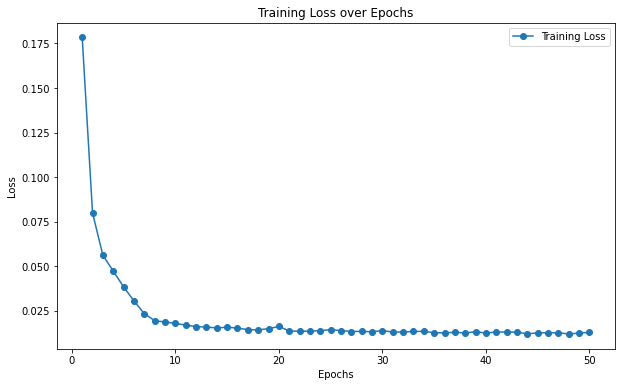

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

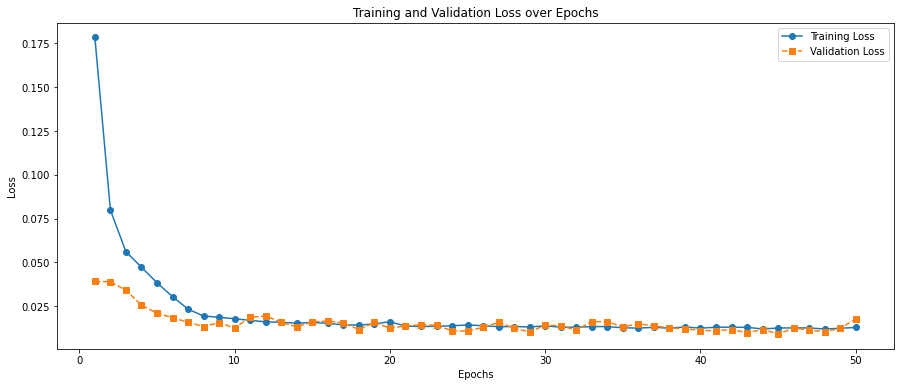

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Barents_model_LT5/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 30ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.09652068136250606
MAE : 0.07887351828859938


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,-54988.882812,14909.156
1,11207.107422,54595.378
2,125448.835938,242829.930
3,264009.937500,406860.687
4,405978.437500,605897.837
5,519745.187500,654073.790
6,578081.500000,701143.910
7,546854.062500,657891.340
8,442569.656250,432215.421
9,249613.125000,201834.787


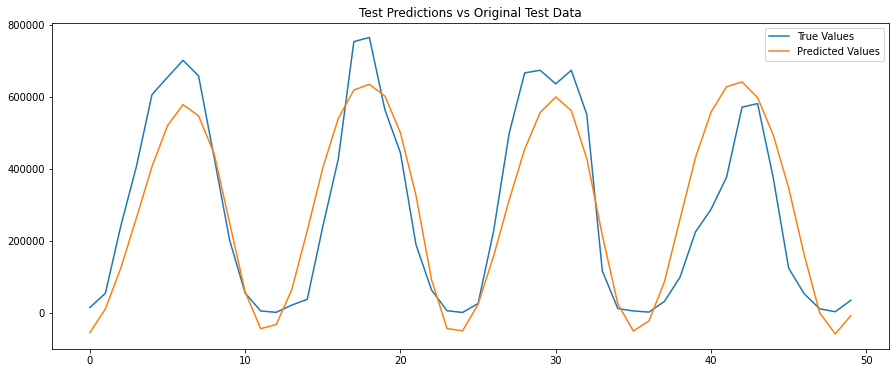

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 21ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

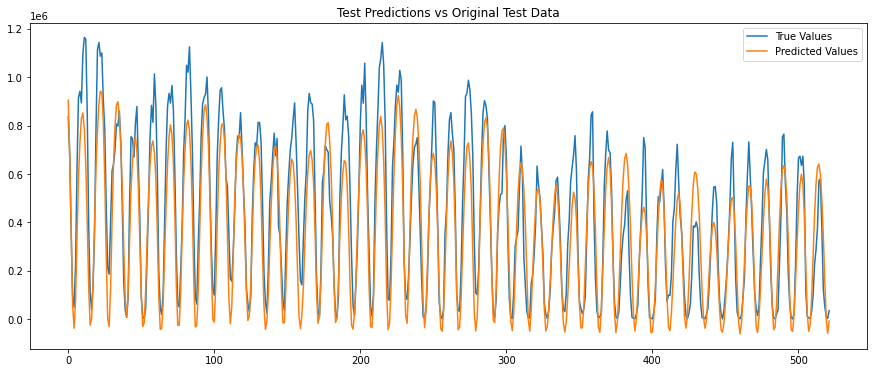

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()